In [7]:
import numpy as np
import os
CurrentPath = os.getcwd()
data_1 = np.loadtxt(CurrentPath + '/2025/data_1.txt', delimiter=' ')
X = data_1.T[0];Y = data_1.T[1]; var = data_1.T[2]

In [5]:
import nestle

#define loglikelihood
def loglike_linear(theta):
    model = linear(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

#define models
def linear(x, theta):
    y= theta[0]*x + theta[1]
    return y
def cube(x,theta):
    y = theta[0]*x**3 + theta[1]*x**2 + theta[2]*x + theta[3]
    return y
def quadratic(x,theta):
    y = theta[0]*x**2 + theta[1]*x + theta[2]
    return y
def exponential(x,theta):
    y = theta[0]*np.exp(theta[1]*x) + theta[2]
    return y
def powerlaw(x,theta):
    y = theta[0]*x**theta[1] + theta[2]
    return y
#define prior
def prior(x):
    theta = 1000 * x - 500
    return theta

In [15]:
import scipy
def func(x, a, b):
    y = a * x + b
    return y

scipy.optimize.curve_fit(func, X, Y, sigma = np.sqrt(var))

(array([   5726.20779798, -117888.5778707 ]),
 array([[ 3.56760102e+05, -1.42047271e+07],
        [-1.42047271e+07,  8.10199055e+08]]))

### Let's make MCMC again!

1. make a code that accounts for a prior
2. make a code that calculates the acceptance ratio from the burn-in period -> ratio to 0.1 <= accept/total <= 0.4
3. do 100 steps -> calculate accept ratio -> use std to proposed gaussian 
4. if 10 times accept ratio converges between that area, do the chain
5. remove the burn-in after the chain is finished

In [ ]:
from tqdm import tqdm

# 1. make a code that acoounts for a prior



def Markov(paramk,paramkp1,x,y,var):
    minuschisqk = -chisq(x,y,var,paramk[0],paramk[1],paramk[2],paramk[3])/2
    minuschisqkp1 = -chisq(x,y,var,paramkp1[0],paramkp1[1],paramkp1[2],paramkp1[3])/2
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk  
# 0 < a < 1, sigma_a = 0.005
# -2.6 < b < -2.4, sigma_b = 0.1
# 6.7 < c < 6.9, sigma_c = 0.1
# 16 < d < 18 sigma_d = 1
def MCMC(paraminit, nstep,normal_vec,x,y,var):
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    for k in tqdm(range(nstep)):
        paramkp1 = np.array([param0[0] + random.normal(0,normal_vec[0]), param0[1]+ random.normal(0,normal_vec[1]),
                              param0[2]+random.normal(0,normal_vec[2]), param0[3]+random.normal(0,normal_vec[3])]) # step size
        param0, loglikelihood = Markov(param0, paramkp1,x,y,var) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

### linear function

In [22]:
import matplotlib.pyplot as plt
import corner


def prior_linear(x):
    theta = np.array([30,50]) * x + np.array([5716,-117870])
    return theta

result_linear = nestle.sample(loglike_linear, prior_linear, 2,npoints=1000, method='single')
nestle.print_progress(result_linear)
print(result_linear.summary(), f"\nlogzerr: {result_linear.logzerr}")
p_linear, cov_linear = nestle.mean_and_cov(result_linear.samples, result_linear.weights)
print(f"Best-fit parameters: a = {p_linear[0]:.3f} +/- {np.sqrt(cov_linear[0,0]):.3f}")
print(f"Best-fit parameters: b = {p_linear[1]:.3f} +/- {np.sqrt(cov_linear[1,1]):.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, linear(X, p_linear), label='Best-fit linear model')
plt.text(0.1,13, f"y = {p_linear[0]:.3f}x + {p_linear[1]:.3f}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
fig = corner.corner(result_linear.samples,weights=result_linear.weights, labels=['a', 'b'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

RuntimeError: Negative h encountered (h=-426956775.350708). Please report this as a likely bug.

### quadratic func

(array([  102.84103167, -3808.53901512, 28194.93525741]),
 array([[ 1.02660133e+01, -9.51797508e+02,  1.45826549e+04],
        [-9.51797508e+02,  9.60426694e+04, -1.66250220e+06],
        [ 1.45826549e+04, -1.66250220e+06,  3.84240854e+07]]),
 {'fvec': array([ 44955.64821452,  23599.44112107,    685.05497918,   -583.40294341,
          -6702.77544949, -11755.20631655, -13098.55969061, -26055.75017898,
         -24813.73950368, -22601.07128048, -19638.36415684, -16775.89962335,
         -12168.3393345 ,  -8317.19242069,  -7033.43126709,   2187.94986701,
          10508.23615764,  15514.27956847,  17704.14447257,  29325.98143565,
          38903.35454449,  38350.52577382,   1452.19539143, -18559.31254666,
         -35083.76526681]),
  'nfev': 13,
  'fjac': array([[-3.40180202e+04,  1.43688962e-03,  5.56289833e-03,
           5.94062271e-03,  8.13894874e-03,  1.06025638e-02,
           1.13999749e-02,  3.21407801e-02,  4.72917270e-02,
           5.58862795e-02,  6.48415249e-02,  7.2451979

In [31]:
#define prior

def prior_quadratic(x):
    theta = np.array([20,90,40]) * x + np.array([102.84103167 - 10,-3808.53901512 - 45,28194.93525741 - 20])
    return theta

def loglike_quadratic(theta):
    model = quadratic(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_quadratic = nestle.sample(loglike_quadratic, prior, 3,npoints=1000, method='single', callback=nestle.print_progress)
print(result_quadratic.summary(), f"\nlogzerr: {result_quadratic.logzerr}")
p_quadratic, cov_quadratic = nestle.mean_and_cov(result_quadratic.samples, result_quadratic.weights)
print(f"Best-fit parameters: {p_quadratic[0]:.3f} +/- {np.sqrt(cov_quadratic[0,0]):.3f}")
print(f"Best-fit parameters: {p_quadratic[1]:.3f} +/- {np.sqrt(cov_quadratic[1,1]):.3f}")
print(f"Best-fit parameters: {p_quadratic[2]:.3f} +/- {np.sqrt(cov_quadratic[2,2]):.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, quadratic(X, p_quadratic), label='Best-fit quad model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_quadratic[0]:.3f}x^2 + {p_quadratic[1]:.3f}x + {p_quadratic[2]:.3f}")
plt.legend()
fig = corner.corner(result_quadratic.samples,weights=result_quadratic.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()

it= 39474 logz=-58986723606.2017298620

KeyboardInterrupt: 

### cubic function

niter: 27285
ncall: 70764
nsamples: 28285
logz: -28.212 +/-  0.157
h: 24.599 
logzerr: 0.15684034859923568
Best-fit parameters: 0.750 +/- 0.000
Best-fit parameters: -2.500 +/- 0.001
Best-fit parameters: 6.795 +/- 0.038
Best-fit parameters: 17.040 +/- 0.374


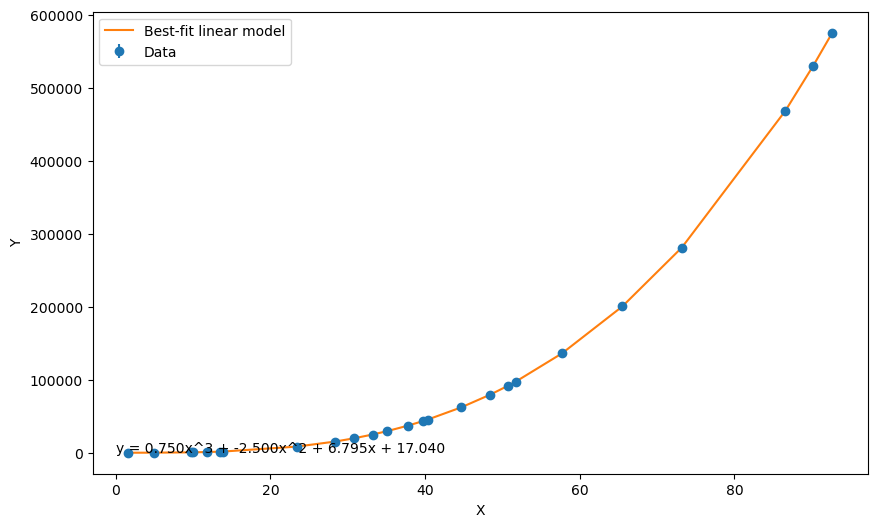

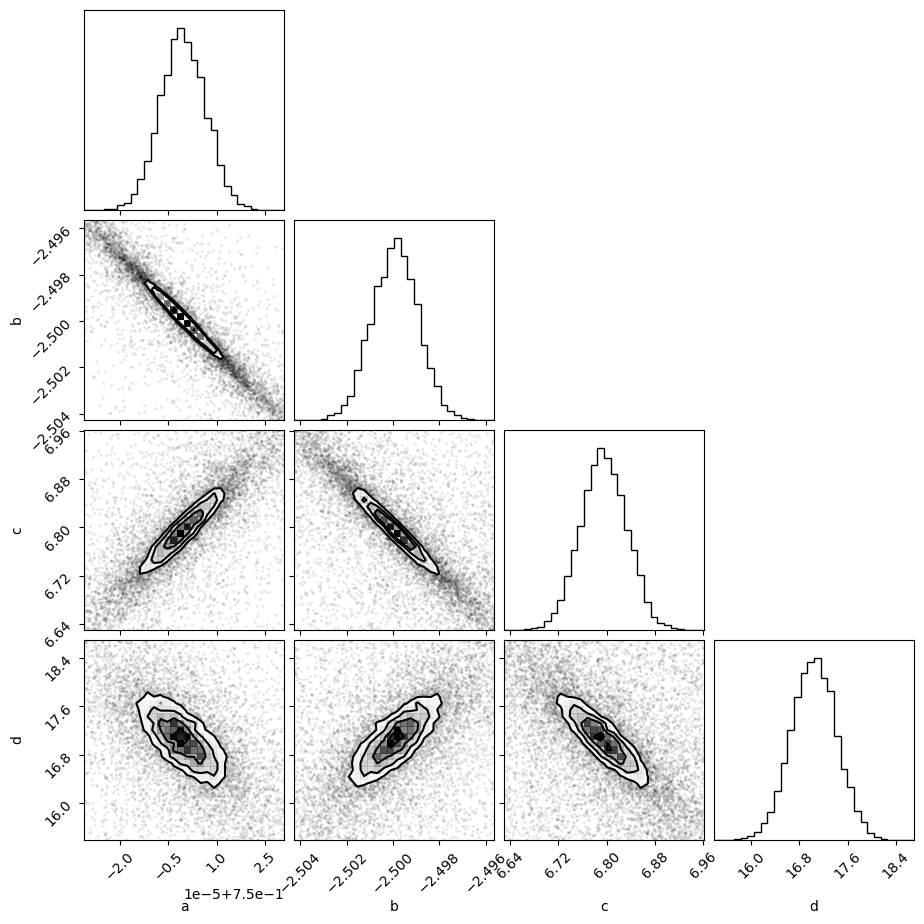

In [28]:
def prior_cubic(x):
    theta = np.array([10,0.05,0.7,10]) * x + np.array([0.75-5,-2.5 - 0.05/2,6.8 - 0.7/2,17.1 - 5])
    return theta


def loglike_cube(theta):
    model = cube(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_cube = nestle.sample(loglike_cube, prior_cubic, 4,npoints=1000, method='single')
print(result_cube.summary(), f"\nlogzerr: {result_cube.logzerr}")
p_cube, cov_cube = nestle.mean_and_cov(result_cube.samples, result_cube.weights)
print(f"Best-fit parameters: {p_cube[0]:.3f} +/- {np.sqrt(cov_cube[0,0]):.3f}")
print(f"Best-fit parameters: {p_cube[1]:.3f} +/- {np.sqrt(cov_cube[1,1]):.3f}")
print(f"Best-fit parameters: {p_cube[2]:.3f} +/- {np.sqrt(cov_cube[2,2]):.3f}")
print(f"Best-fit parameters: {p_cube[3]:.3f} +/- {np.sqrt(cov_cube[3,3]):.3f}")



plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, cube(X, p_cube), label='Best-fit linear model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_cube[0]:.3f}x^3 + {p_cube[1]:.3f}x^2 + {p_cube[2]:.3f}x + {p_cube[3]:.3f}")
plt.legend()

fig = corner.corner(result_cube.samples,weights=result_cube.weights, labels=['a', 'b','c','d'],
                    range=[0.99999, 0.99999,0.99999,0.99999], bins=30)
plt.show()

### exponential function

niter: 17855
ncall: 1559271
nsamples: 18855
logz: -20.048 +/-  0.125
h: 15.559 
logzerr: 0.12473601886424393
Best-fit parameters: 3.534 +/- 1.044
Best-fit parameters: 1.655 +/- 0.236
Best-fit parameters: 0.714 +/- 1.272


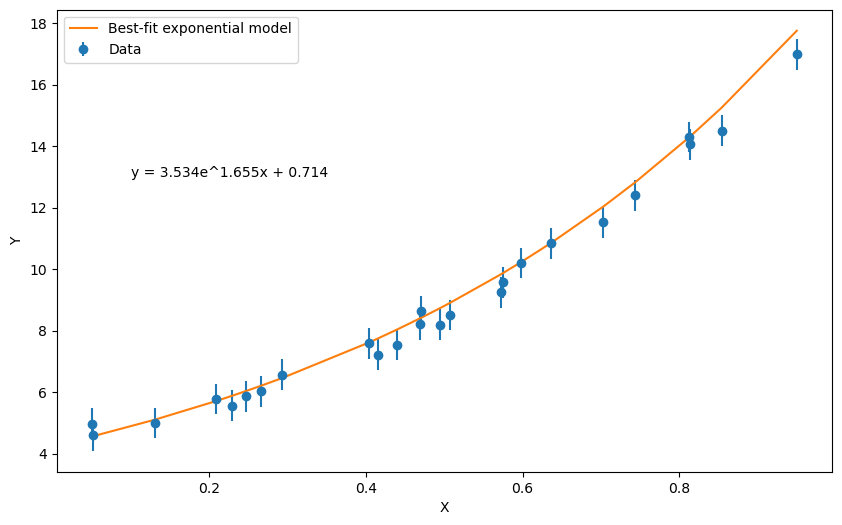

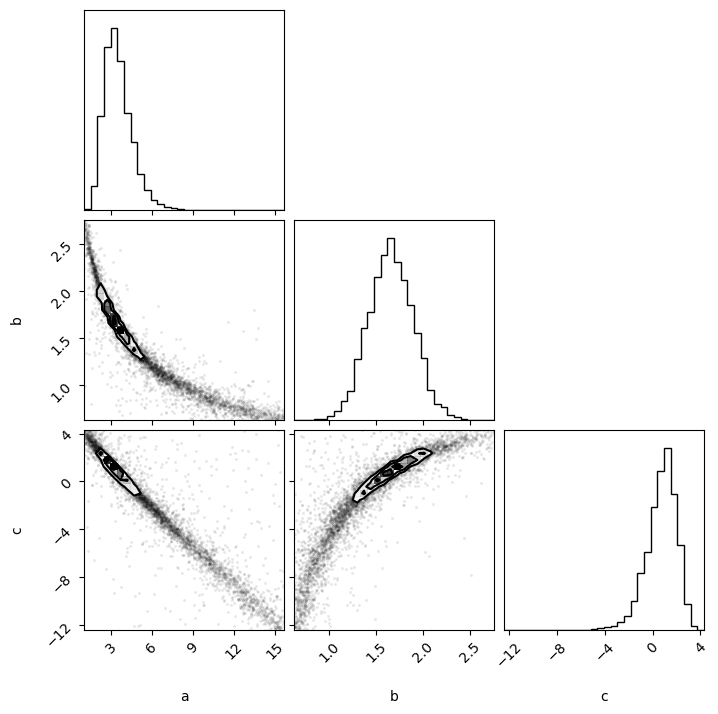

In [14]:
def loglike_exponential(theta):
    model = exponential(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_exponential = nestle.sample(loglike_exponential, prior, 3,npoints=1000, method='single')
print(result_exponential.summary(), f"\nlogzerr: {result_exponential.logzerr}")
p_exponential, cov_exponential = nestle.mean_and_cov(result_exponential.samples, result_exponential.weights)
print(f"Best-fit parameters: {p_exponential[0]:.3f} +/- {np.sqrt(cov_exponential[0,0]):.3f}")
print(f"Best-fit parameters: {p_exponential[1]:.3f} +/- {np.sqrt(cov_exponential[1,1]):.3f}")
print(f"Best-fit parameters: {p_exponential[2]:.3f} +/- {np.sqrt(cov_exponential[2,2]):.3f}")



plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, exponential(X, p_exponential), label='Best-fit exponential model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_exponential[0]:.3f}e^{p_exponential[1]:.3f}x + {p_exponential[2]:.3f}")
plt.legend()

fig = corner.corner(result_exponential.samples,weights=result_exponential.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()


### Power law

niter: 17136
ncall: 935330
nsamples: 18136
logz: -19.058 +/-  0.122
h: 14.834 
logzerr: 0.12179589937417415
Best-fit parameters: 13.335 +/- 0.416
Best-fit parameters: 1.847 +/- 0.135
Best-fit parameters: 4.816 +/- 0.266


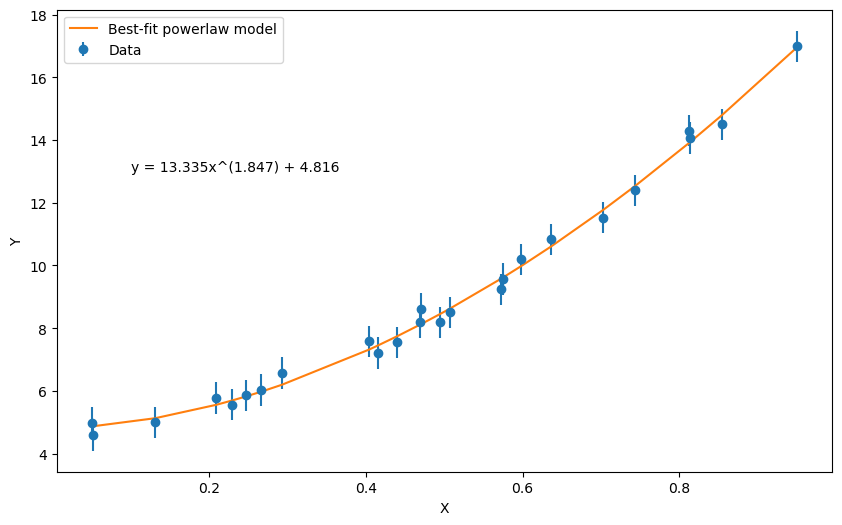

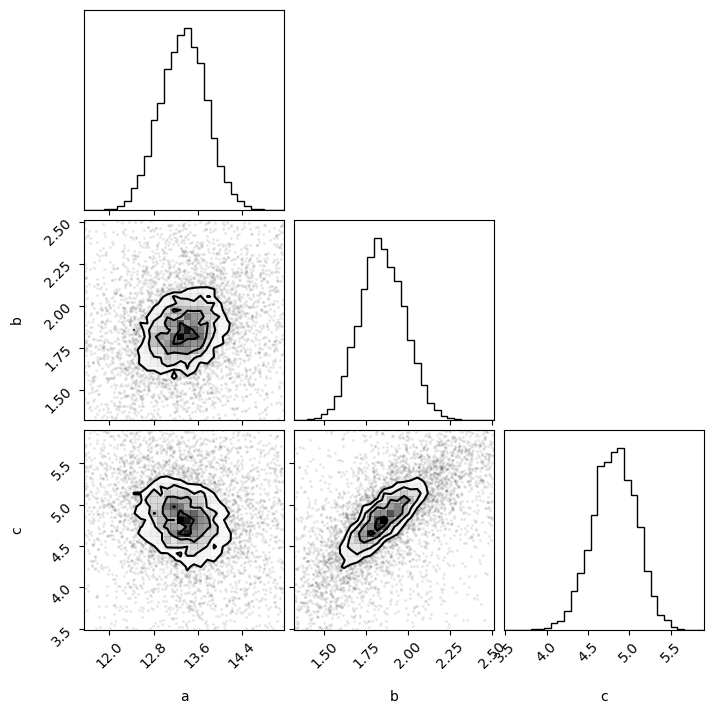

In [15]:


def loglike_powerlaw(theta):
    model = powerlaw(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_powerlaw = nestle.sample(loglike_powerlaw, prior, 3,npoints=1000, method='single')
print(result_powerlaw.summary(), f"\nlogzerr: {result_powerlaw.logzerr}")
p_powerlaw, cov_powerlaw = nestle.mean_and_cov(result_powerlaw.samples, result_powerlaw.weights)
print(f"Best-fit parameters: {p_powerlaw[0]:.3f} +/- {np.sqrt(cov_powerlaw[0,0]):.3f}")
print(f"Best-fit parameters: {p_powerlaw[1]:.3f} +/- {np.sqrt(cov_powerlaw[1,1]):.3f}")
print(f"Best-fit parameters: {p_powerlaw[2]:.3f} +/- {np.sqrt(cov_powerlaw[2,2]):.3f}")


plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, powerlaw(X, p_powerlaw), label='Best-fit powerlaw model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_powerlaw[0]:.3f}x^({p_powerlaw[1]:.3f}) + {p_powerlaw[2]:.3f}")
plt.legend()

fig = corner.corner(result_powerlaw.samples,weights=result_powerlaw.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()
